## Sources:
- [US Congressional Research Service](https://sgp.fas.org/crs/natsec/RS21405.pdf)
- [UVA Miller Center](https://millercenter.org/the-presidency/presidential-speeches)
- [Kaggle Dataset](https://www.kaggle.com/datasets/littleotter/united-states-presidential-speeches)

In [16]:
from silence_tensorflow import silence_tensorflow
silence_tensorflow()

import os
import sys
import string
from collections import Counter

import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import torch
import sklearn
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Embedding, SpatialDropout1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import transformers
from transformers import BertTokenizer, BertModel
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, log_loss, accuracy_score, roc_auc_score, f1_score
from sklearn.model_selection import train_test_split, ShuffleSplit
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from tqdm import tqdm
# Import custom class
from BertSeqVect import BertSequenceVectorizer

# Set wd
os.chdir('/Users/wyattscott/Documents/DS6050/Project')

# Enable tqdm progress bars on pandas
tqdm.pandas()

In [17]:
df = pd.read_csv('Speeches_War_Clean.csv')
df.head(2)

,Date,President,Party,Transcript,War
0,1810-10-27,James Madison,Democratic-Republican,whereas territory south mississippi territory ...,0
1,1810-12-05,James Madison,Democratic-Republican,fellow citizens senate house representatives e...,0


In [18]:
print(len(df['Transcript']))

935


## Class imbalance:

### We adjust this later via SMOTE

In [19]:
old_class_counts = df['War'].value_counts()
print(old_class_counts)

War
0    860
1     75
Name: count, dtype: int64


___

### Vectorization: Applying the vectorize method from the `BertSequenceVectorizer` class to each speech to convert them into fixed-length vectors.

Instantiate BERT tokenizer and model:

In [20]:
# Instantiate BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

Process each transcript using the BERT model to obtain a fixed-length vector representation by using the `BertSequenceVectorizer` class (see BertSeqVect.py). 

The resulting vectors are stored in `df` in the `ts_feature` column.

In [21]:
# Apply BERT sequence vectorization to transcripts
vectorizer = BertSequenceVectorizer()
df['ts_feature'] = df['Transcript'].progress_apply(lambda x: vectorizer.vectorize(x))

100%|█████████████████████████████████████████| 935/935 [00:54<00:00, 17.28it/s]


### Oversample via SMOTE:

Apply SMOTE (Synthetic Minority Over-sampling Technique) to address class imbalance. This effectively oversamples the minority class (`War=1`, in this case) to balance the class distribution. 

Below we generate the resampled features, `X_resampled`, and corresponding labels, `y_resampled`.

In [22]:
# Extract features from 'ts_feature'
X = np.stack(df['ts_feature'].values)

In [23]:
# Apply SMOTE to fix class imbalance
smote = SMOTE(random_state=28)
X_resampled, y_resampled = smote.fit_resample(X, df['War'])

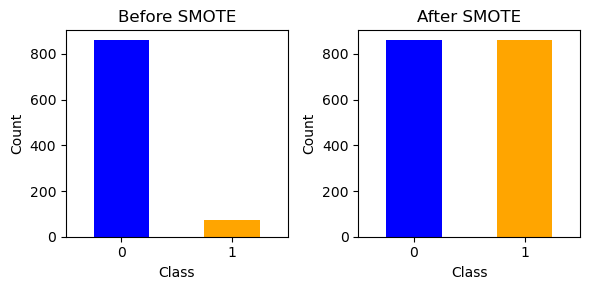

In [24]:
new_class_counts = y_resampled.value_counts()
new_class_counts = new_class_counts.sort_index()

# Visualize change in class imbalance
plt.figure(figsize=(6, 3))

plt.subplot(1, 2, 1)
old_class_counts.plot(kind='bar', color=['blue', 'orange'])
plt.title('Before SMOTE')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=0)

plt.subplot(1, 2, 2)
new_class_counts.plot(kind='bar', color=['blue', 'orange'])
plt.title('After SMOTE')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

### Train/test split

In [25]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, 
                                                    y_resampled, 
                                                    test_size=0.2, 
                                                    random_state=28)

### Exploring a Basic NN

In [26]:
# Define the neural network model
model = Sequential([
    Dense(128, 
          activation='relu', 
          input_shape=(768,),
          kernel_initializer='he_normal', 
          kernel_regularizer=keras.regularizers.l2(0.01)),
    Dropout(0.1),
    Dense(64, 
          activation='relu',
          kernel_initializer='he_normal',
          kernel_regularizer=keras.regularizers.l2(0.01)),
    Dropout(0.1),
    Dense(1, 
          activation='sigmoid',
          kernel_initializer='he_normal',
          kernel_regularizer=keras.regularizers.l2(0.01))
])

In [27]:
#opt = tf.keras.optimizers.Adam(learning_rate=0.001, weight_decay=0.01)#, use_ema=True, ema_momentum=0.9)
opt = tf.keras.optimizers.legacy.SGD(learning_rate=0.001, momentum=0.99, nesterov=True)
#opt = tf.keras.optimizers.Adadelta(learning_rate=0.01, use_ema=True, ema_momentum=0.99)

# Compile the model
model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy']) 

In [28]:
# Train the model
history = model.fit(X_train, y_train,
                    epochs=15,
                    batch_size=16,
                    validation_split=0.2)

Epoch 1/15
69/69 [==============================] - 1s 17ms/step - loss: 4.4873 - accuracy: 0.5355 - val_loss: 4.2056 - val_accuracy: 0.6522
Epoch 2/15
69/69 [==============================] - 1s 13ms/step - loss: 3.9490 - accuracy: 0.6009 - val_loss: 3.5879 - val_accuracy: 0.6812
Epoch 3/15
69/69 [==============================] - 1s 13ms/step - loss: 3.2704 - accuracy: 0.6591 - val_loss: 2.9214 - val_accuracy: 0.6449
Epoch 4/15
69/69 [==============================] - 1s 13ms/step - loss: 2.6229 - accuracy: 0.6845 - val_loss: 2.3497 - val_accuracy: 0.6014
Epoch 5/15
69/69 [==============================] - 1s 13ms/step - loss: 2.0987 - accuracy: 0.7155 - val_loss: 1.8481 - val_accuracy: 0.7138
Epoch 6/15
69/69 [==============================] - 1s 13ms/step - loss: 1.6417 - accuracy: 0.7745 - val_loss: 1.4739 - val_accuracy: 0.7862
Epoch 7/15
69/69 [==============================] - 1s 13ms/step - loss: 1.3045 - accuracy: 0.7936 - val_loss: 1.1544 - val_accuracy: 0.8188
Epoch 8/15
69

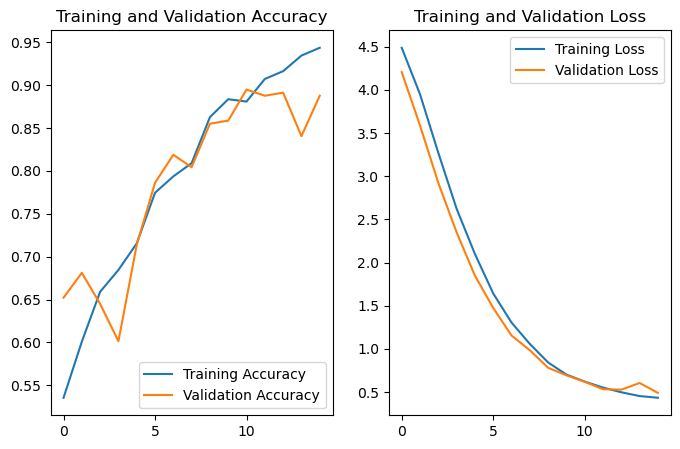

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(15)

plt.figure(figsize=(8, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [30]:
# Predict probs for positive class
y_pred_prob = model.predict(X_test)

# AUC-ROC score
auc_roc = roc_auc_score(y_test, y_pred_prob)

# Convert probs to class labels
y_pred_class = (y_pred_prob > 0.5).astype(int)

# F1-score
f1 = f1_score(y_test, y_pred_class)

print("AUC-ROC Score:", auc_roc)
print("F1-Score:", f1)

11/11 [==============================] - 0s 2ms/step
AUC-ROC Score: 0.9752096861471862
F1-Score: 0.934844192634561


---

# Comments on model results:

These results possibly indicate that there are discernible patterns in the text of US presidential speeches that correlate with the US entering a major war  within one year of the speech. This (I think) suggests that Presidents leverage certain language or rhetorical cues in their speeches to prepare the nation for war.